In [6]:
import tensorflow as tf
import numpy as np
import PIL
from PIL import Image
import os
import matplotlib.pyplot as plt
from focal_loss import BinaryFocalLoss
from sklearn.metrics import accuracy_score
import requests

In [9]:
# necessary for using the google collab together with the images dataset

# from google.colab import drive
# drive.mount('/content/drive')

# import sys
# sys.path.insert(0,'/content/drive/My Drive/Colab Notebooks')

In [10]:
# prefix = "./drive/MyDrive/ML_DATA/deforestation"
prefix = "."

In [11]:
# load images



## training
training_images_list = os.listdir(r"{}/data/training/images/".format(prefix))
training_masks_list = []
training_images = []
for n in training_images_list:
  im = PIL.Image.open(r"{}/data/training/images/{}".format(prefix, n))
  training_images.append(im)
  training_masks_list.append(n[:-5]+'.png')

## trainging masks
training_masks = []
for n in training_masks_list:
  im = PIL.Image.open(r"{}/data/training/masks/{}".format(prefix, n))
  training_masks.append(im)

## validation
validation_images_list = os.listdir(r"{}/data/validation/images/".format(prefix))
validation_masks_list = []
validation_images = []
for n in validation_images_list:
  im = PIL.Image.open(r"{}/data/validation/images/{}".format(prefix, n))
  validation_images.append(im)
  validation_masks_list.append(n[:-5]+'.png')

## validation masks
validation_masks = []
for n in validation_masks_list:
  im = PIL.Image.open(r"{}/data/validation/masks/{}".format(prefix, n))
  validation_masks.append(im)

## testing
test_images_list = os.listdir(r"{}/data/test/".format(prefix))
test_images = []
for n in test_images_list:
  im = PIL.Image.open(r"{}/data/test/{}".format(prefix, n))
  test_images.append(im)


In [12]:
for i in range(len(training_images)):
  training_images[i] = np.array(training_images[i])/255
  training_images[i] = training_images[i].reshape(512,512,3)
  training_images[i] = training_images[i].astype('float32')

for i in range(len(training_masks)):
  training_masks[i] = (np.array(training_masks[i])-1)
  training_masks[i] = training_masks[i][:512,:512]
  training_masks[i] = training_masks[i].reshape(512,512,1)
  training_masks[i] = training_masks[i].astype('int')

for i in range(len(validation_images)):
  validation_images[i] = np.array(validation_images[i])/255
  validation_images[i] = validation_images[i].reshape(1,512,512,3)
  validation_images[i] = validation_images[i].astype('float32')

for i in range(len(validation_masks)):
  validation_masks[i] = np.array(validation_masks[i])-1
  validation_masks[i] = validation_masks[i][:512,:512]
  validation_masks[i] = validation_masks[i].reshape(1,512,512,1)
  validation_masks[i] = validation_masks[i].astype('int')

for i in range(len(test_images)):
  test_images[i] = np.array(test_images[i])/255
  test_images[i] = test_images[i].reshape(1,512,512,3)
  test_images[i] = test_images[i].astype('float32')

In [13]:
training_images = np.array(training_images)
training_masks = np.array(training_masks)

validation_images = np.array(validation_images)
validation_masks = np.array(validation_masks)

In [14]:
def learning_curve(model_fit, key='acc', ylim=(0.8, 1.01)):
    plt.figure(figsize=(12,6))
    plt.plot(model_fit.history[key])
    plt.plot(model_fit.history['val_' + key])
    plt.title('Learning Curve')
    plt.ylabel(key.title())
    plt.xlabel('Epoch')
    plt.ylim(ylim)
    plt.legend(['train', 'test'], loc='best')
    plt.show()

In [15]:
def reconstruct_image(model, image, threshold_value = 0.8):
    predicted = model.predict(image)
    predicted = np.where(predicted > threshold_value, 1, 0)
    predicted = (predicted + 1) % 2
    mask_image = Image.fromarray(predicted[0, :, :, 0] * 255)

    return mask_image

def reconstruct_image_array(model, images, threshold_value = 0.8):
    predicted = model.predict(images).reshape(512, 512)

    predicted = np.where(predicted > threshold_value, 1, 0)

    return predicted # Returns array


def score_eval(model, image, mask, threshold_value = .8, type='list'):
    if type != 'list':   
        predicted = model.predict(image)
        predicted = np.where(predicted > threshold_value, 1, 0)

        predicted = predicted.flatten()

        return accuracy_score(mask.flatten(), predicted)

    else:
        scores = []
        mean_accuracy = 0
        for i in range(len(image)):
            predicted = model.predict(image[i])
            predicted = np.where(predicted > threshold_value, 1, 0)
            predicted = predicted.flatten()

            accuracy = accuracy_score(mask[i].flatten(), predicted)
            scores.append(accuracy)
            mean_accuracy += accuracy

        mean_accuracy /= len(image)
        return scores, mean_accuracy

def get_IoU(predicted, mask):
    TP = 0
    FP = 0
    FN = 0
    
    for i in range(len(predicted)):
        TP += 1 if predicted[i] == mask[i] and predicted[i] == 1 else 0
        FP += 1 if predicted[i] != mask[i] and predicted[i] == 1 else 0
        FN += 1 if predicted[i] != mask[i] and predicted[0] == 1 else 0

    if TP + FP + FN == 0:
        return 0
    return TP / (TP + FP + FN)

def get_mean_IoU(model, images, masks, threshold_value):
    scores = []
    mean_IoU = 0
    
    for i in range(len(images)):
        predicted = model.predict(images[i])
        predicted = np.where(predicted > threshold_value, 1, 0)
        predicted = predicted.flatten()

        IoU = get_IoU(predicted, masks[i].flatten())
        scores.append(IoU)
        mean_IoU += IoU

    mean_IoU /= len(images)
    return scores, mean_IoU



### Simple conv net

In [16]:
cnet_model = tf.keras.models.load_model(r"{}/models/custom-model/model".format(prefix))
cnet_model.summary()

# learning_curve(cnet_model, key='loss', ylim=(0, 1))

metrics = cnet_model.evaluate(np.asarray(validation_images[0]), np.asarray(validation_masks[0]), batch_size=8)

print('Validation loss:', metrics[0])
print('Validation accuracy:', metrics[1])

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 512, 512, 32  896         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 256, 256, 32  0          ['conv2d_20[0][0]']              
                                )                                                           

1/1 [==============================] - 0s 264ms/step


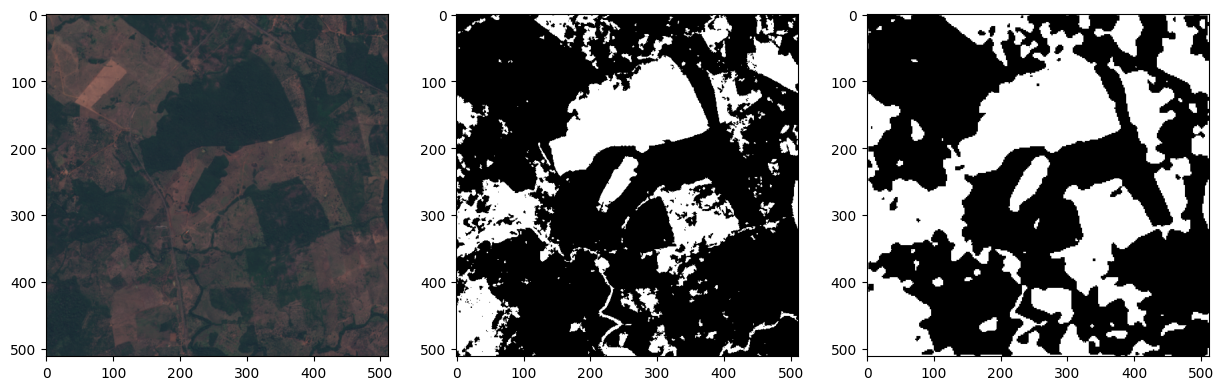

In [17]:
image = PIL.Image.open(r"{}/data/validation/images/{}".format(prefix, validation_images_list[1]))
mask = PIL.Image.open(r"{}/data/validation/masks/{}".format(prefix, validation_images_list[1][:-5]+'.png'))

mask_image = reconstruct_image(cnet_model, validation_images[1])

fig, axs = plt.subplots(1, 3, figsize=(15,6))
axs[0].imshow(image)
axs[1].imshow(mask, cmap='gray')
axs[2].imshow(mask_image, cmap='gray')


### U-Net

In [18]:
unet_model = tf.keras.models.load_model(r"{}/models/u-net/model/".format(prefix))
unet_model.summary()

print(unet_model.history)
# learning_curve(cnet_model, key='loss', ylim=(0, 1))

metrics = unet_model.evaluate(np.asarray(validation_images[0]), np.asarray(validation_masks[0]), batch_size=8)

print('Validation loss:', metrics[0])
print('Validation accuracy:', metrics[1])

Model: "u_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(1, 512, 512, 3)]   0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (1, 512, 512, 64)    1792        ['input_2[0][0]']                
                                                                                                  
 activation (Activation)        (1, 512, 512, 64)    0           ['conv2d_5[0][0]']               
                                                                                                  
 conv2d_6 (Conv2D)              (1, 512, 512, 64)    36928       ['activation[0][0]']             
                                                                                              

### Seg-Net

In [19]:
segnet_model = tf.keras.models.load_model(r"{}/models/seg-net/model/".format(prefix))
segnet_model.summary()

print(segnet_model.history)
# learning_curve(cnet_model, key='loss', ylim=(0, 1))

metrics = segnet_model.evaluate(np.asarray(validation_images[0]), np.asarray(validation_masks[0]), batch_size=8)

print('Validation loss:', metrics[0])
print('Validation accuracy:', metrics[1])

Model: "seg_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 512, 512, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d_24[0][0]']              
 alization)                     )                                                           

1/1 [==============================] - 2s 2s/step


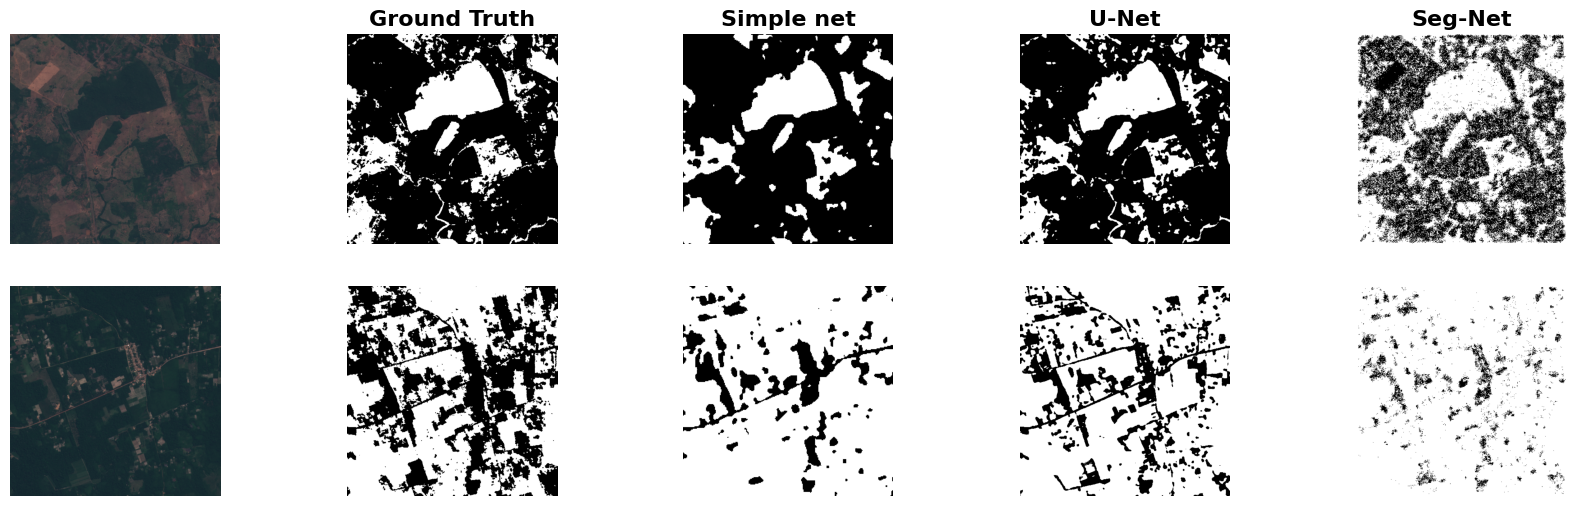

In [28]:
from matplotlib.patches import Circle


mask_image_cnet = reconstruct_image(cnet_model, validation_images[1], threshold_value=0.3)
mask_image_unet = reconstruct_image(unet_model, validation_images[1], threshold_value=0.6)
mask_image_segnet = reconstruct_image(segnet_model, validation_images[1], threshold_value=0.6)
image = PIL.Image.open(r"{}/data/validation/images/{}".format(prefix, validation_images_list[1]))
mask = PIL.Image.open(r"{}/data/validation/masks/{}".format(prefix, validation_images_list[1][:-5]+'.png'))

mask_image_cnet_2 = reconstruct_image(cnet_model, validation_images[2], threshold_value=0.3)
mask_image_unet_2 = reconstruct_image(unet_model, validation_images[2], threshold_value=0.6)
mask_image_segnet_2 = reconstruct_image(segnet_model, validation_images[2], threshold_value=0.6)
image_2 = PIL.Image.open(r"{}/data/validation/images/{}".format(prefix, validation_images_list[2]))
mask_2 = PIL.Image.open(r"{}/data/validation/masks/{}".format(prefix, validation_images_list[2][:-5]+'.png'))

fig, axs = plt.subplots(2, 5, figsize=(21,6))
axs[0, 0].imshow(image)
axs[0, 1].imshow(mask, cmap='gray')
axs[0, 2].imshow(mask_image_cnet, cmap='gray')
axs[0, 3].imshow(mask_image_unet, cmap='gray')
axs[0, 4].imshow(mask_image_segnet, cmap='gray')

axs[1, 0].imshow(image_2)
axs[1, 1].imshow(mask_2, cmap='gray')
axs[1, 2].imshow(mask_image_cnet_2, cmap='gray')
axs[1, 3].imshow(mask_image_unet_2, cmap='gray')
axs[1, 4].imshow(mask_image_segnet_2, cmap='gray')

for i in range(2):
    for j in range(5):
        axs[i][j].axis('off')
        axs[i][j].set_aspect('equal')



# Set titles
axs[0, 1].set_title('Image', size=16, weight="bold")
axs[0, 1].set_title('Ground Truth', size=16, weight="bold")
axs[0, 2].set_title('Simple net', size=16, weight="bold")
axs[0, 3].set_title('U-Net', size=16, weight="bold")
axs[0, 4].set_title('Seg-Net', size=16, weight="bold")


#fig.tight_layout()
fig.subplots_adjust(wspace=0.2, hspace=0.2)
fig.savefig('masks-comparison.pdf', bbox_inches = 'tight', pad_inches = 0.1)

## Threshold motivation

## Mean Intersection over Union (mIoU)

In [21]:
mean_IoUs_cnet = [] 
mean_IoUs_unet = []
mean_IoUs_segnet = []

for threshold in range(1, 10):
    threshold /= 10

    _, mean_IoU_cnet = get_mean_IoU(cnet_model, validation_images, validation_masks, threshold)
    _, mean_IoU_unet = get_mean_IoU(unet_model, validation_images, validation_masks, threshold)
    _, mean_IoU_segnet = get_mean_IoU(segnet_model, validation_images, validation_masks, threshold)
  
    mean_IoUs_cnet.append(mean_IoU_cnet)
    mean_IoUs_unet.append(mean_IoU_unet)
    mean_IoUs_segnet.append(mean_IoU_segnet)

1/1 [==============================] - 2s 2s/step


[0.6525784991161665, 0.6798394027144834, 0.8463403845962157, 0.8935047654394993, 0.9362798315409702, 0.8755232848347682, 0.8991447323860012, 0.9080881447493179, 0.9292441875639735]
[0.6041608018277597, 0.679160191953231, 0.7318725682380176, 0.8541793902612003, 0.8814802850277293, 0.9285859098474698, 0.9544960704054498, 0.9737260964857851, 0.9933913329198035]
[0.3964173089659522, 0.3964173089659522, 0.3964173089659522, 0.3964741898890273, 0.5693462738841991, 0.8996541334792097, 0.9260030676717165, 0.5333333333333333, 0.06666666666666667]


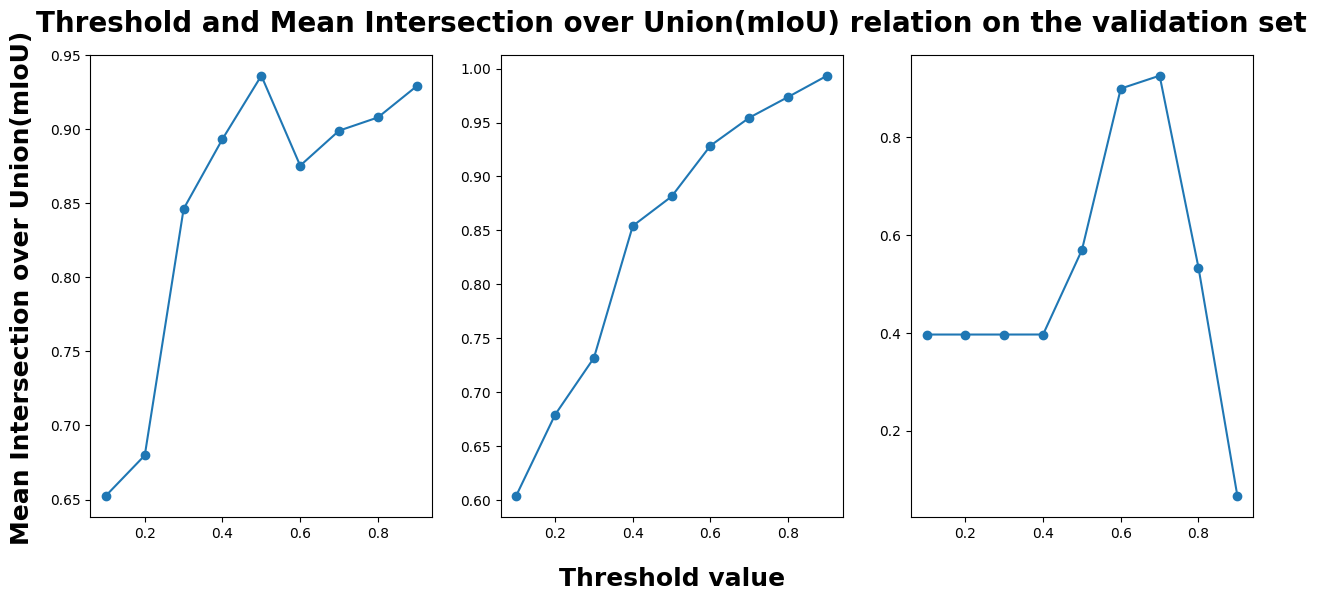

In [22]:
print(mean_IoUs_cnet)
print(mean_IoUs_unet)
print(mean_IoUs_segnet)

thresholds = [i/10 for i in range(1, 10)]

fig, axs = plt.subplots(1, 3, figsize=(15,6))

axs[0].plot(thresholds, mean_IoUs_cnet, marker='o', linestyle='-')

axs[1].plot(thresholds, mean_IoUs_unet, marker='o', linestyle='-')

axs[2].plot(thresholds, mean_IoUs_segnet, marker='o', linestyle='-')

fig.subplots_adjust(wspace=0.2, hspace=0.2)
axs[1].text(0.5,1.05, "Threshold and Mean Intersection over Union(mIoU) relation on the validation set", size=20, ha="center", 
         transform=axs[1].transAxes, weight="bold")
axs[1].text(0.5,-0.15, "Threshold value", size=18, ha="center", 
         transform=axs[1].transAxes, weight="bold")
axs[0].text(-0.2,-0.05, "Mean Intersection over Union(mIoU)", size=18, ha="center", 
         transform=axs[0].transAxes, weight="bold", rotation=90)
plt.show()

## Accuracy

In [23]:
mean_accuracies_cnet = [] 
mean_accuracies_unet = []
mean_accuracies_segnet = []

for threshold in range(1, 10):
    threshold /= 10

    _, mean_accuracy_cnet = score_eval(cnet_model, validation_images, validation_masks, threshold)
    _, mean_accuracy_unet = score_eval(unet_model, validation_images, validation_masks, threshold)
    _, mean_accuracy_segnet = score_eval(segnet_model, validation_images, validation_masks, threshold)
  
    mean_accuracies_cnet.append(mean_accuracy_cnet)
    mean_accuracies_unet.append(mean_accuracy_unet)
    mean_accuracies_segnet.append(mean_accuracy_segnet)



1/1 [==============================] - 2s 2s/step


[0.889758555094401, 0.8955083211263021, 0.8871106465657552, 0.8769777933756511, 0.866229756673177, 0.8544685363769531, 0.840021260579427, 0.8199590047200521, 0.783764394124349]
[0.8506640116373698, 0.8976829528808594, 0.917577616373698, 0.927252197265625, 0.9302060445149739, 0.9282030741373698, 0.9214739481608073, 0.9084772745768229, 0.8810325622558594]
[0.5222007751464843, 0.5222007751464843, 0.5222007751464843, 0.5223553975423177, 0.6398025512695312, 0.7569269816080729, 0.4844716389973958, 0.47783584594726564, 0.4778027852376302]


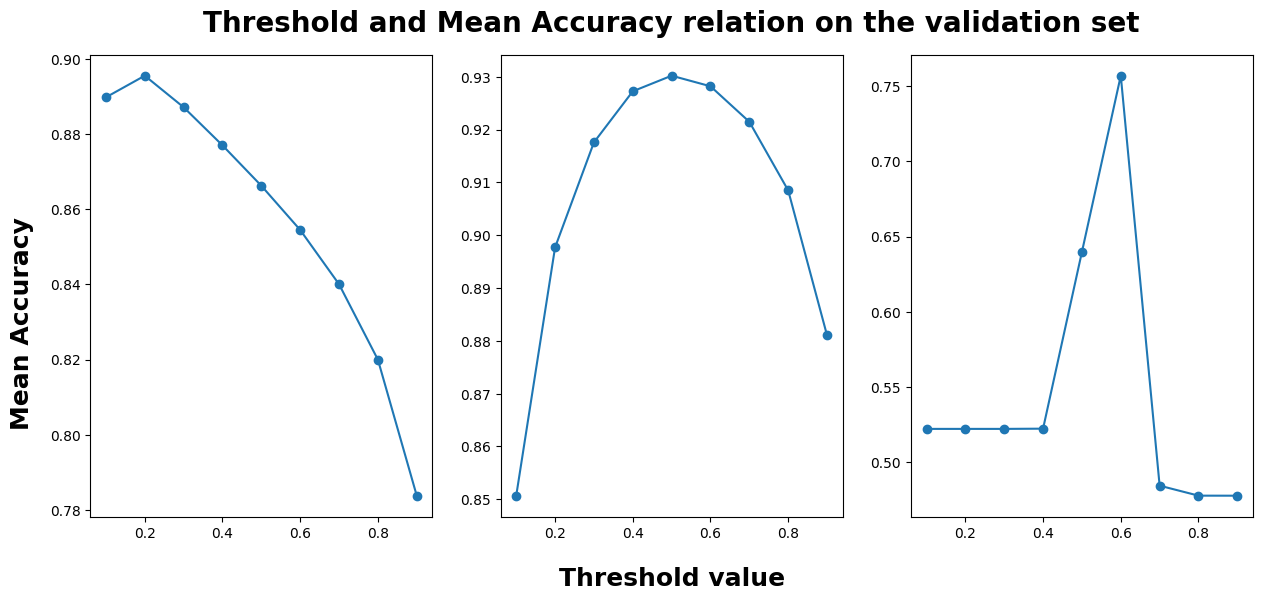

In [24]:
print(mean_accuracies_cnet)
print(mean_accuracies_unet)
print(mean_accuracies_segnet)

thresholds = [i/10 for i in range(1, 10)]

fig, axs = plt.subplots(1, 3, figsize=(15,6))

axs[0].plot(thresholds, mean_accuracies_cnet, marker='o', linestyle='-')

axs[1].plot(thresholds, mean_accuracies_unet, marker='o', linestyle='-')

axs[2].plot(thresholds, mean_accuracies_segnet, marker='o', linestyle='-')

fig.subplots_adjust(wspace=0.2, hspace=0.2)
axs[1].text(0.5,1.05, "Threshold and Mean Accuracy relation on the validation set", size=20, ha="center", 
         transform=axs[1].transAxes, weight="bold")
axs[1].text(0.5,-0.15, "Threshold value", size=18, ha="center", 
         transform=axs[1].transAxes, weight="bold")
axs[0].text(-0.2,0.2, "Mean Accuracy", size=18, ha="center", 
         transform=axs[0].transAxes, weight="bold", rotation=90)
plt.show()

### Confusion matrix

In [25]:
import itertools
from sklearn.metrics import confusion_matrix

predictions_simple = [list(reconstruct_image_array(cnet_model, image, threshold_value=0.3).flatten()) for image in validation_images]
predictions_unet = [list(reconstruct_image_array(unet_model, image, threshold_value=0.5).flatten()) for image in validation_images]
predictions_segnet = [list(reconstruct_image_array(segnet_model, image, threshold_value=0.6).flatten()) for image in validation_images]
actual = [list(mask.flatten()) for mask in validation_masks]

simple_u   = list(itertools.chain.from_iterable(predictions_simple))
unet_u  = list(itertools.chain.from_iterable(predictions_unet))
segnet_u  = list(itertools.chain.from_iterable(predictions_segnet))
actual_u   = list(itertools.chain.from_iterable(actual))


simple_confmat = confusion_matrix(actual_u, simple_u)
unet_confmat = confusion_matrix(actual_u, unet_u)
segnet_confmat = confusion_matrix(actual_u, segnet_u)

1/1 [==============================] - 2s 2s/step


In [26]:
# print([list(mask.flatten()) for mask in validation_masks[:1]])
# print([list(reconstruct_image_array(segnet_model, image).flatten()) for image in validation_images[:1]])

[[1756563  122220]
 [ 321679 1731698]]
[[1755575  123208]
 [ 151233 1902144]]
[[1817906   60877]
 [ 894925 1158452]]


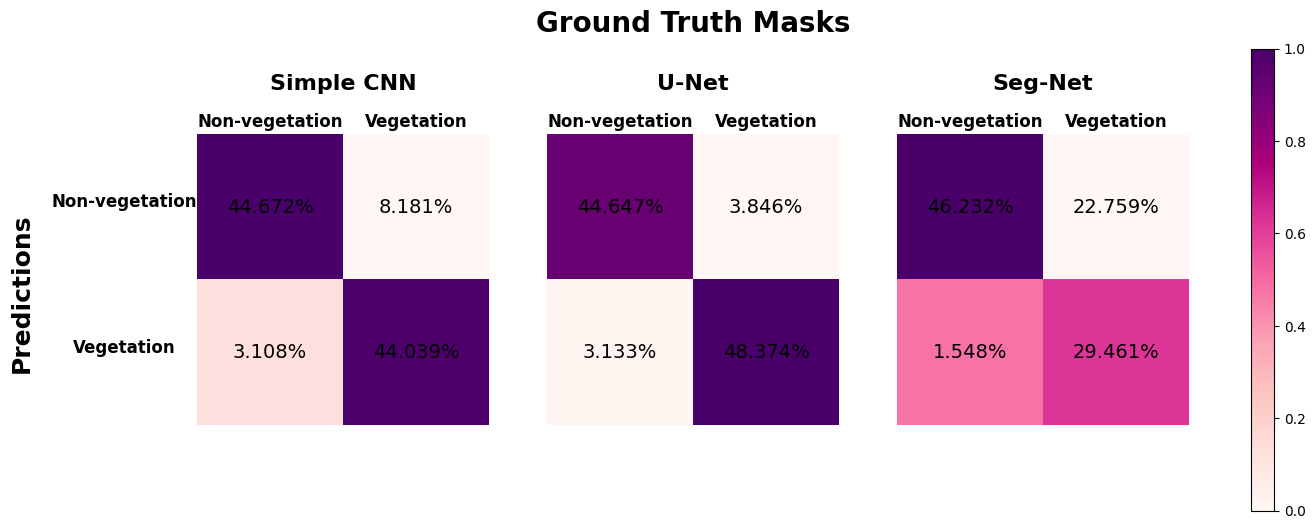

In [27]:
print(simple_confmat)
print(unet_confmat)
print(segnet_confmat)

labels = ['Non-vegetation', 'Vegetation']
fig, axs = plt.subplots(1, 3, figsize=(16,6))
axs[0].set_xticks(np.arange(len(labels)))
axs[0].set_yticks(np.arange(len(labels)))


# Set labels of axes
axs[0].set_xticklabels(labels, size=14)
axs[0].set_yticklabels(labels, size=14)

rounding = 3
sz = 14
col = 'black'

for i in range(len(labels)):
    for j in range(len(labels)):
      if i == 0 and j == 0 or i == 1 and j == 1:
        col2 = 'white'
      else:
        col2 = col
        
      text = axs[0].text(i, j, '{}%'.format(np.round(100*simple_confmat[i, j]/simple_confmat.sum(), rounding)),
                      ha="center", va="center", color='black', size=sz)
      
for i in range(len(labels)):
    for j in range(len(labels)):
      if i == 0 and j == 0 or i == 1 and j == 1:
        col2 = 'white'
      else:
        col2 = col
        
      text = axs[1].text(i, j, '{}%'.format(np.round(100*unet_confmat[i, j]/unet_confmat.sum(), rounding)),
                      ha="center", va="center", color='black', size=sz)
        
for i in range(len(labels)):
    for j in range(len(labels)):
      if i == 0 and j == 0:
        col2 = 'white'
      else:
        col2 = col
        
      text = axs[2].text(i, j, '{}%'.format(np.round(100*segnet_confmat[i, j]/segnet_confmat.sum(), rounding)),
                       ha="center", va="center", color='black', size=sz)
      
# Remove axis, adjust spacing
axs[0].axis('off')
axs[1].axis('off')
axs[2].axis('off')

axs[0].set_aspect('equal')
axs[1].set_aspect('equal')
axs[2].set_aspect('equal')

# Add titles
axs[1].text(0.5,1.35, "Ground Truth Masks", size=20, ha="center", 
         transform=axs[1].transAxes, weight="bold")

axs[0].text(0.5,1.15, "Simple CNN", size=16, ha="center", 
         transform=axs[0].transAxes, weight="bold")

axs[1].text(0.5,1.15, "U-Net", size=16, ha="center", 
         transform=axs[1].transAxes, weight="bold")

axs[2].text(0.5,1.15, "Seg-Net", size=16, ha="center", 
         transform=axs[2].transAxes, weight="bold")

# Plot
tone = 'RdPu'
axs[0].imshow(simple_confmat, cmap=tone)
axs[1].imshow(unet_confmat, cmap=tone)
axs[2].imshow(segnet_confmat, cmap=tone)


axs[0].text(-0.6,0.2, "Predictions", size=18, ha="center", 
         transform=axs[0].transAxes, weight="bold", rotation=90)


# Add left labels
axs[0].text(-0.25,0.75, labels[0], size=12, ha="center", 
         transform=axs[0].transAxes, weight="bold")
axs[0].text(-0.25,0.25, labels[1], size=12, ha="center", 
         transform=axs[0].transAxes, weight="bold")


# Add top labels
axs[0].text(0.25,1.025, labels[0], size=12, ha="center", 
         transform=axs[0].transAxes, weight="bold")
axs[0].text(0.75,1.025, labels[1], size=12, ha="center", 
         transform=axs[0].transAxes, weight="bold")

axs[1].text(0.25,1.025, labels[0], size=12, ha="center", 
         transform=axs[1].transAxes, weight="bold")
axs[1].text(0.75,1.025, labels[1], size=12, ha="center", 
         transform=axs[1].transAxes, weight="bold")

axs[2].text(0.25,1.025, labels[0], size=12, ha="center", 
         transform=axs[2].transAxes, weight="bold")
axs[2].text(0.75,1.025, labels[1], size=12, ha="center", 
         transform=axs[2].transAxes, weight="bold")
      
fig.subplots_adjust(wspace=0.2, hspace=0.2)
fig.colorbar(plt.cm.ScalarMappable(cmap=tone), ax=axs)
fig.savefig('confusion_matrix.pdf', bbox_inches = 'tight', pad_inches = 0.1)